<center> <font size=6>《Auto-Encoding Variational Bayes》论文复现

# 论文及背景介绍

&emsp;&emsp;本篇论文是2013年由Diederik P. Kingma, Max Welling初次发出的著名论文，2014年修订了最终版，最终版在当年被ICLR（International Conference on Learning Representations）收录，本文复现的是最终版。本篇论文提出了变分自编码器（Variational Autoencoder）（VAE），由此拉开了生成模型的热潮，2014年的生成式对抗网络（Generative Adversarial Networks）（GAN），也是在这种背景下诞生的。VAE和GAN都是著名的生成模型，GAN的实际效果比VAE好，但是VAE的数学理论非常优美，并且可解释性强，而GAN的直观性强，现在的趋势是这两种生成模型的融合。\
&emsp;&emsp;在本篇论文中，作者使用了两种算法来训练VAE，一种是Neal在1995年提出的Wake-Sleep算法（醒眠算法），另一种是基于随机梯度的AEVB算法，选择不同的隐变量维度，在两个数据集上对这两种算法进行了比较，一个数据集是著名的手写数字体数据集，即MNIST数据集，另一个是人脸数据集，即Frey Face数据集。\
&emsp;&emsp;由于本人能力有限，只复现了本篇论文的AEVB算法，并没有复现醒眠算法。醒眠算法也是一个非常有趣的启发式算法，最初用于训练信念网络，也叫做贝叶斯网络，是一个有向概率图模型，2006年Hinton将醒眠算法应用到深度信念网络（DBN）上。他的两阶段即Wake阶段训练的目标是正向KL散度，但是Sleep阶段训练的目标是逆向KL散度，因为KL散度并不是一个对称性的距离度量，因此两阶段训练的目标函数并不一致，所以被称为醒眠算法，“醒”的时候目标是我们要的，“眠”的时候并不是我们要的目标。\
&emsp;&emsp;由于运行时间过长，本文只对MNIST数据集做实验，只选择隐变量维度为3、5、10的情况，并且训练样本数达到10^7时就停止。

# 变分自编码器理论简介

## 生成模型简介

&emsp;&emsp;生成模型相对于判别模型，判别模型是指对$p(y|x)$的条件概率进行建模，而生成模型是对$p(x,y)$的联合概率密度进行建模，根据贝叶斯公式，$p(x,y)=p(x|y)p(y)$因此生成模型可以根据标签生成样本，这是显著不同于判别模型的特点。<br>
&emsp;&emsp;生成模型主要应用于无监督学习，也可以应用于监督学习，即$p(x,y)=p(y|x)p(x)$，对于无监督学习，生成模型对数据分布$p(x)$进行建模，对含有隐变量的数据，如假定数据由隐变量$z$生成，相当于是对$p(x,z)$的联合概率密度进行建模。<br>
&emsp;&emsp;典型的生成模型有朴素贝叶斯、隐马尔可夫模型（HMM）、高斯混合模型（GMM），典型的判别模型有神经网络、Logistic回归、支持向量机（SVM）。

## 概率图模型简介

&emsp;&emsp;概率图模型（PGM），是一种用图结构来描述多元随机变量之间条件独立关系的概率模型，对高维空间中的概率模型带来了很大的便捷性，因为条件独立性大大减少参数的数量。\
&emsp;&emsp;图模型由节点，边组成，节点包括观测变量和隐变量，边表示条件概率。概率图具体分为有向图模型和无向图模型，有向图模型是指节点与节点之间是单向的联系，连接边由单向的箭头连接，表示单向的条件概率，无向图模型是指节点与节点之间是双向的交互关系，具有双向的条件概率的表达式。\
&emsp;&emsp;概率图模型的基本问题：\
&emsp;&emsp;（1）表示问题，即如何用图结构的形式表示整个模型。\
&emsp;&emsp;（2）学习问题，有了一个图结构，如何学习模型的参数，即参数估计问题，常见的估计方法为最大似然估计。\
&emsp;&emsp;（3）推断问题，在已知部分变量，计算其他变量的条件概率。对于含有隐变量的模型，推断问题主要是指在观测变量给定的情况下，导致这一现象出现的隐变量概率是多少，即求解$p(z|x)$，常见的求解方法有两大类，精确推断和近似推断，精确推断比如变量消除法，近似推断比如变分推断，MCMC。

## VAE模型

&emsp;&emsp;变分自编码器（Variational Autoencoder）是概率图模型和神经网络的结合，是一种基于似然的生成模型。它由两部分组成，编码器和解码器，编码器用于接收数据作为输入，并将其转换为潜在表示，并输入给解码器解码，用以重建数据。它采用变分推断近似模型的后验。

### 模型表示

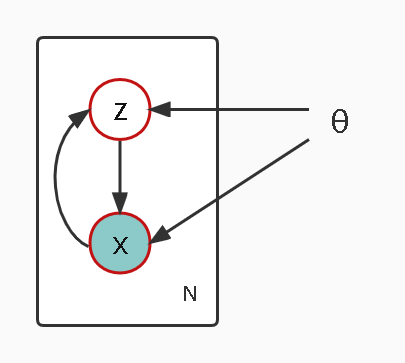
<center> 理想状态

&emsp;&emsp;上图是理想状态下的表示方法，$\theta$为模型参数，$ x, z $ 分别为观测变量和隐变量，我们要建立的模型为$p_\theta(x,z)$，请注意，这三个变量均为向量。为什么说是理想状态呢，因为从$z$到$x$可以是我们事先确定的机制，比如高斯混合模型，$z$表示不同的高斯分布，$x$是从生成于高斯分布的，他们的关系可以很容易的确定，问题是在$x$到$z$的有向边，我们简单的推导一下,为方便起见，我们省略参数。
$$p(z|x) = \frac{p(z,x)}{p(x)} = \frac{p(x|z)p(z)}{p(x)} \tag{1}$$
&emsp;&emsp;$p(x)$正是我们要建模的对象，我们假定存在隐变量，因此:
$$p(x)=\int_{z}p(x,z) dx = \int_{z_1} \int_{z_2} ... \int_{z_J}p(x,z_1,z_2,...,z_J)\;dz_1 dz_2 ... dz_J \tag{2}$$
&emsp;&emsp;$z$的下标指的是$z$的维度，我们假设$z$有$J$维，因此如果$z$只有一两维还是可以直接可解的，但实际上有很多维，求解的复杂度是指数级的，所以当维度很大时，这几乎是个不可解问题，因为$p(x)$不可解，$p(z|x)$也无法直接得到，因此我们更改我们的图表示方法。

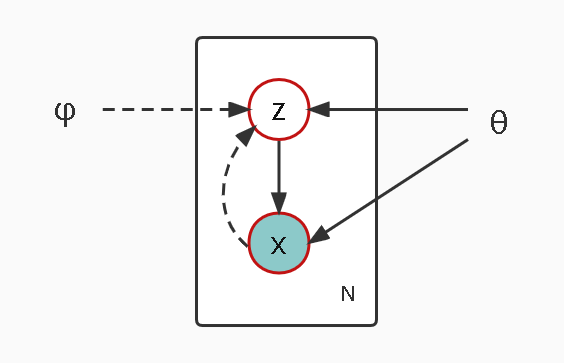
<center> VAE模型

&emsp;&emsp;因为$p(z|x)$的难处理（intractable），我们采用近似的方法，用一个概率分布$q_\varphi(z|x)$去近似$p_\theta(z|x)$，$q_\varphi(z|x)$又叫做变分分布，用变分分布不断逼近真实的条件分布，这就是变分推断的思想。那么问题来了，变分分布怎么选择呢，如何衡量$q(z|x)$和$p(z|x)$的相似程度呢，根据通用近似定理，神经网络可以拟合一个任意函数，因此我们可以利用神经网络来拟合这个变分分布，这就是VAE的思想。

### 数学推导

&emsp;&emsp;我们知道衡量两个分布之间的差异使用最多的是$KL$散度，$KL$散度也叫做相对熵，对于离散分布，其计算公式为：
$$KL(p||q)=\sum_x p(x)\frac{p(x)}{q(x)} \tag{3}$$ 
&emsp;&emsp;为方便推导，我们将参数写在函数里面，我们采用最大似然估计，因此我们的目标函数为：
$$\max_{\theta}p(x;\theta)=\max_{\theta}log\;p(x;\theta)\tag{4}$$
$$\begin{align} 
log \; p(x;\theta) &= log \; p(x,z;\theta) - log \; p(z|x;\theta) \\
&= log \frac{p(x,z;\theta)}{q(z|x;\varphi)}-log \frac{p(z|x;\theta)}{q(z|x;\varphi)}\tag{5}
\end{align}$$ \
&emsp;&emsp;我们将等式两边同时乘$q(z|x;\varphi)$并对$z$求积分，因为$\int_z q(z|x;\varphi)=1$，因此，$$等式左边=\int_z q(z|x;\varphi)log \; p(x;\theta)\; dz=log \; p(x;\theta) $$
$$\begin{align} 
log \; p(x;\theta) &= \int_z q(z|x;\varphi)log \frac{p(x,z;\theta)}{q(z|x;\varphi)} \; dz - 
\int_z q(z|x;\varphi)log \frac{p(z|x;\theta)}{q(z|x;\varphi)} \; dz  \\
&=E_{q(z|x;\varphi)} \left[log \frac{p(x,z;\theta)}{q(z|x;\varphi)} \right] + KL\left(q(z|x;\varphi) || p(z|x;\theta) \right) \\
&=ELBO(q,x;\theta,\varphi)+KL\left(q(z|x;\varphi) || p(z|x;\theta) \right) \tag{6}
\end{align} $$ \
&emsp;&emsp;其中，$ELBO(q,x;\theta,\varphi)=E_{q(z|x;\varphi)} \left[log \frac{p(x,z;\theta)}{q(z|x;\varphi)} \right]$称为证据下界，又叫做变分下界。$KL$散度大于等于0，$log\;p(x;\theta)$对数似然函数也叫做证据，因此$ELBO$叫做证据下界。固定$\theta$，已知样本时，似然函数是一个定值，因此如果我们不断的提高证据下界，相当于间接的减小了两个分布之间的$KL$散度。

### VAE的基本思想

&emsp;&emsp;既然变分分布$q(z|x;\varphi)$,和生成分布$p(x|z;\theta)$都是事先人为假设的，也就是说需要专家知识，那么我们可不可以通过神经网络强大的拟合能力直接拟合这两个分布呢，答案是可以的，这就是VAE的基本思想。\
&emsp;&emsp;VAE由两部分组成，一部分是推断网络（Encoder）$f_e(x;\varphi)$，用来来逼近变分分布$q(z|x;\varphi)$，另一部分是生成网络（Decoder）$f_d(z;\theta)$，用来来逼近生成分布$p(x|z;\theta)$，因为酷似于编码器解码器，比如，你可以将推断网络看做一个概率编码器，最终将数据编码成一定维度的格式，将信息编码至隐变量$z$里，将生成网络看做一个概率解码器，用于恢复原始数据，所以这就是VAE名字的由来，变分自编码器。

## VAE的学习问题

&emsp;&emsp;我们会用神经网络来逼近两个分布，即用推断网络（Encoder）$f_e(x;\varphi)$来逼近$q(z|x;\varphi)$，用生成网络（Decoder）$f_d(z;\theta)$来逼近$p(x|z;\theta)$。理论上，这两个网络都可以逼近任意分布，可以是非参数化的分布，但为了模型的可解释性以及推导，我们假定两个网络都服从同一类分布，比如指数族分布，本文选择高斯分布，因为$x$是$D$维的连续变量。\
&emsp;&emsp;为防止混乱，我们先进行分布的假设：
$$p(z;\theta)=\mathcal{N}(z;0,I)\;,\;q(z|x;\varphi)=\mathcal{N}(z;\mu_e,\sigma_e^2I)\;,\;p(x|z;\theta)=\mathcal{N}(x;\mu_d,\lambda I) \tag{7}$$
&emsp;&emsp;其中，$(\mu_e,\sigma_e)$分别为推断网络$f_e(x;\varphi)$的输出；$\mu_d$是生成网络$f_d(z;\theta)$的输出；$\lambda$是事先指定的超参数，是一个标量，用于控制方差的大小。请注意，这里的$\sigma_e^2I$不是矩阵乘法，$\sigma_e^2$不是标量，而是$J$维向量，$\sigma_e^2I$是一个协方差对角矩阵，$\sigma_e^2$是该矩阵对角元素的向量，所以$\sigma_e^2 I = diag(\sigma_e^2)$。因此，在我们的假定下，推断网络服从一个各向异性的高斯分布，而生成网络服从各项同性的高斯分布。\
&emsp;&emsp;生成网络是依据$x$的类型假设的，如果$x \in \{0,1\}^D$是$D$维的二值变量，可以假设$p(x|z;\theta)$服从多变量的伯努利分布，如果$x \in \mathbb R^D$是$D$维的连续变量，可以假设$p(x|z;\theta)$是多维高斯分布。

### 推断网络的目标

&emsp;&emsp;在公式（7）的假设下，推断网络$f_e(x;\varphi)$的输出是参数化的，即$f_e(x;\varphi) \rightarrow (\mu_e,\sigma_e)$，推断网络的隐藏层可以是全连接层或卷积层，输出层是线性层，不用加激活函数，这是为了保证均值有正有负，而方差是非负的，因此可以让线性层学习$log\sigma_e$，这样就保证了方差是非负的。\
&emsp;&emsp;推断网络的目标是使得$q(z|x;\varphi)$尽可能的接近真实的后验$p(z|x;\theta)$，需要找到一组参数$\varphi^*$来最小化两个分布的$KL$散度,即
$$\varphi^*=\mathop{\arg\min}\limits_{\varphi}KL\left(q(z|x;\varphi)||p(z|x;\theta) \right) \tag{8}$$
&emsp;&emsp;但是上面提到过，$p(z|x;\theta)$几乎是不可解的，传统的方法是采样法或变分推断，但是采样的效率很低，速度很慢，也并没有那么准确，一般是采用变分推断，即用一个简单的分布$q$去近似复杂的分布$p(z|x;\theta)$，但是遇到$p(z|x;\theta)$非常复杂的时候，就很难用简单分布去近似，因此采用间接的手段，根据式（6）的推导，推断网络的目标函数可以转换为：
$$\begin{align} \varphi^* &=\mathop{\arg\min}\limits_{\varphi}KL\left(q(z|x;\varphi)||p(z|x;\theta)\right)\\
&=\mathop{\arg\min}\limits_{\varphi}log \; p(x;\theta) - ELBO(q,x;\theta,\varphi) \\
&=\mathop{\arg\max}\limits_{\varphi}ELBO(q,x;\theta,\varphi)\tag{9}\end{align}$$
&emsp;&emsp;即推断网络的目标转换为寻找一组参数$\varphi^*$使得证据下界$ELBO(q,x;\theta,\varphi)$最大化，这和变分推断的转换类似。

### 生成网络的目标

&emsp;&emsp;生成网络的目标是找到一组参数$\theta^*$最大化证据下界$ELBO(q,x;\theta,\varphi)$,即：
$$\theta^*=\mathop{\arg\max}\limits_{\theta}ELBO(q,x;\theta,\varphi)\tag{10}$$

### 整体目标的推导

&emsp;&emsp;我们终于去掉了$p(z|x;\theta)$这个大麻烦，$p(z|x;\theta)$并不在证据下界里。推断网络和生成网络的目标是一致的，都是最大化证据下界，因此我们可以保证VAE训练的收敛性，为方便我们分析和优化，我们进一步推导VAE的总目标函数（也即原文献2.3节中的SGVB估计方法的B方法）：
$$\begin{align}
\max_{\theta,\varphi}ELBO(q,x;\theta,\varphi)&=\max_{\theta,\varphi}E_{q(z|x;\varphi)} \left[log \frac{p(x,z;\theta)}{q(z|x;\varphi)}\right]\\
&=\max_{\theta,\varphi}E_{q(z|x;\varphi)} \left[log \frac{p(x|z;\theta)p(z;\theta)}{q(z|x;\varphi)}\right]\\
&=\max_{\theta,\varphi}E_{q(z|x;\varphi)} \left[log \; p(x|z;\theta) +log \frac{p(z;\theta)}{q(z|x;\varphi)}\right]\\
&=\max_{\theta,\varphi}E_{q(z|x;\varphi)} \left[log \; p(x|z;\theta) \right] - KL\left(q(z|x;\varphi)||p(z;\theta)\right) \tag{11}
\end{align}$$
&emsp;&emsp;其中，$p(z;\theta)$为隐变量$z$的先验分布。\
&emsp;&emsp;我们分别来看看公式中的两项。\
&emsp;&emsp;（1）公式中的第一项期望，通常使用采样的方式来近似计算，对于每个样本$x$，从$q(z|x;\varphi)$中采集L个$z^{(l)}$，就有
$$E_{q(z|x;\varphi)} \left[log\;p(x|z;\theta) \right] \approx \frac{1}{L} \sum_{l=1}^L log \; p(x|z^{(l)};\theta) \tag{12}$$
&emsp;&emsp;这样的处理是没有问题的，但是会发现这个期望与参数$\varphi$无关了，原本是确定性关系，但近似后变成了随机采样的关系，因此我们不能使用随机梯度下降来学习这个参数了，原文献中使用了重参数化技巧，让$z$的随机性来源于另一个简单的随机变量$\epsilon$，这样就可以使用随机梯度下降算法了，重参数化技巧后面会写。\
&emsp;&emsp;（2）公式第二项的$KL$散度通常可以直接计算，因为这两个分布通常比较相似，一个是隐变量$z$的先验，另一个是后验，可以假定属于同一个类型的指数族分布，比如高斯分布，我们以高斯分布为例。\
&emsp;&emsp;给定$J$维空间中的两个高斯分布$\mathcal{N}(\mu_1,\Sigma_1)$和$\mathcal{N}(\mu_2,\Sigma_2)$，其$KL$散度为
$$\begin{align} &KL\left(\mathcal{N}(\mu_1,\Sigma_1)||\mathcal{N}(\mu_2,\Sigma_2)\right)\\
=&\frac{1}{2}\left(tr(\Sigma_2^{-1}\Sigma_1)+(\mu_2-\mu_1)^T\Sigma_2^{-1}(\mu_2-\mu_1)-J+log \frac{|\Sigma_2|}{|\Sigma_1|}\right)\tag{13}\end{align}$$
&emsp;&emsp;这样，当我们假定先验后验均为高斯分布时，我们就能直接计算出$KL$散度。具体的，我们上面假定了$p(z;\theta)=\mathcal{N}(z;0,I),q(z|x;\varphi)=\mathcal{N}(z;\mu_e,\sigma_e^2I)$，其中$\mu_e,\sigma_e$分别为推断网络$f_e(x;\varphi)$的输出，再次强调，这里的$\sigma_e^2I$不是矩阵乘法，$\sigma_e^2$是$J$维向量，$\sigma_e^2I$是一个协方差对角矩阵，$\sigma_e^2$是该矩阵对角元素的向量。在这样的假定下，可以很容易的得到两个分布的$KL$散度，即
$$\begin{align}&KL\left(q(z|x;\varphi)||p(z;\theta) \right) \\
=&\frac{1}{2} \left(tr(\sigma_e^2I)+\mu_e^T\mu_e-J-log(|\sigma_e^2I|)\right)\tag{14}\end{align}$$

### 重参数化技巧

&emsp;&emsp;我们对优化目标的第一项进行采样近似，导致参数消失了，变成了随机采样的关系，而不是确定的关系了，因此我们需要将参数复原出来，这就是重参数化技巧。\
&emsp;&emsp;我们观察$E_{q(z|x;\varphi)} \left[log p(x|z;\theta) \right]$，这个期望的计算依赖于分布$q$的参数$\varphi$，但是由于随机变量$z$采样自后验分布$q(z|x;\varphi)$,因此他们之间不再是确定性的关系，我们想办法把$z$的随机性转入其他随机变量，找到一个$z$关于参数$\varphi$的确定性关系，再去不断采样这个随机变量就大功告成了，等于变相的采样$z$。\
&emsp;&emsp;我们引入一个随机变量$\epsilon$，他服从一个简单分布$p(\epsilon)$，这样,$E_{q(z|x;\varphi)} \left[log p(x|z;\theta) \right]$可以重写为
$$E_{q(z|x;\varphi)} \left[log p(x|z;\theta) \right]=E_{p(\epsilon)}\left[log \; p(x|g(\varphi,\epsilon);\theta)\right]\tag{15}$$
&emsp;&emsp;其中，$z=g(\varphi,\epsilon)$为一个确定性的函数。\
&emsp;&emsp;具体的，我们假设$q(z|x;\varphi)$为高斯分布$\mathcal{N}(\mu_e,\sigma_e^2)$，其中$(\mu_e,\sigma_e)$是推断网络$f_e(x;\varphi)$的输出，推断网络必须依赖于参数$\varphi$，这样才能进行梯度下降算法，我们通过以下方式进行重参数化：
$$z=\mu_e+\sigma_e \odot \epsilon \tag{16}$$
&emsp;&emsp;其中$\epsilon \sim \mathcal{N}(0,I)$，$\odot$代表逐元素点积，如$[x \odot y]_i=x_iy_i$。非常棒，这样我们就把$z$和参数$\varphi$从采样关系变为确定性关系了。


## VAE的训练

&emsp;&emsp;我们在上一节推导了VAE的优化目标，即最大化证据下界，但是在训练过程中，我们更喜欢最小化损失函数，用损失函数来分析模型，并作为模型的衡量标准。因此在本节中，我们先制定优化算法，这一步骤对应于原文献中的2.3节。接下来，依据我们公式（7）的高斯分布假设，对优化目标进一步的推导，使其更加具体化，这一步骤对应于原文献中的第3大节。最后，我们会在原文献的基础上，将优化目标转换为最小化损失函数，并进一步推导，最终解释VAE在训练过程中的真正目标。

### AEVB优化算法

&emsp;&emsp;现有一个数据集$X=\{x^{(i)}\}_{n=1}^N$， AEVB算法的思想是，每轮迭代，选择$M$个样本训练，计算证据下界的平均值，代表每个样本计算的证据下界，最终乘以样本量$N$，代表所有样本计算的证据下界，也就是说，每一轮迭代，模型并没有按照批次训练所有的样本，而是仅仅随机抽样了$M$个样本进行学习。\
&emsp;&emsp;根据公式（11）和（12），对于每一个样本$x^{(i)}$，VAE的优化目标为：
$$\begin{align}
\mathcal{L}(\theta,\varphi|x^{(i)}) &=ELBO(q,x^{(i)};\theta,\varphi) \\
&\approx \frac{1}{L}\sum_{l=1}^L log\;p(x^{(i)}|z^{(i,l)};\theta) - KL\left(q(z|x^{(i)};\varphi)||p(z;\theta)\right) \tag{17}
\end{align}$$
&emsp;&emsp;对于所有样本$X$，VAE的优化目标为：
$$\mathcal L (\theta,\varphi|X) \approx \mathcal L(\theta,\varphi|X^M)=\frac{N}{M}\sum_{i=1}^M \mathcal L(\theta,\varphi|x^{(i)}) \tag{18}
$$
&emsp;&emsp;其中，$X^M=\{x^{(i)}\}_{i=1}^M$是从所有数据集中随机抽样$M$个。\
&emsp;&emsp;在原文献中，$M=100\;,\;L=1$，也就是说，每次迭代训练只抽样100个样本进行训练，从高斯噪声中只采样一个值计算隐变量$z$，采样一个值直接当做期望计算，而不是用平均值。

### 优化目标

&emsp;&emsp;为方便推导，我们对一个样本$x$不加上角标，根据公式（17），VAE的优化目标为：
$$\begin{align}
\max_{\theta,\varphi}\mathcal{L}(\theta,\varphi|x) \approx \frac{1}{L}\sum_{l=1}^L log\;p(x|z^{(l)};\theta) - KL\left(q(z|x;\varphi)||p(z;\theta)\right) \tag{19}
\end{align}$$
&emsp;&emsp;依据公式（14）以及公式（7）的假定，有
$$\begin{align}
- KL\left(q(z|x;\varphi)||p(z;\theta)\right) &= -\frac{1}{2} \left(tr(\sigma^2I)+\mu^T\mu-J-log(|\sigma^2I|)\right) \\
&=\frac{1}{2}\left(J+log(\prod_{j=1}^J \sigma_j^2)- \sum_{j=1}^J\sigma_j^2-\sum_{j=1}^J\mu_j^2 \right)\\
&=\frac{1}{2}\sum_{j=1}^J(1+log\sigma_j^2-\sigma_j^2-\mu_j^2) \tag{20}
\end{align}$$

&emsp;&emsp;带入式（19）得
$$\mathcal{L}(\theta,\varphi|x) \approx \frac{1}{L}\sum_{l=1}^L log\;p(x|z^{(l)};\theta) + \frac{1}{2}\sum_{j=1}^J(1+log\sigma_j^2-\sigma_j^2-\mu_j^2))\tag{21}$$
&emsp;&emsp;考虑数据集$X=\{x^{(i)}\}_{n=1}^N$，对于一个样本$x^{(i)}$，随机采样$L$个变量$\epsilon^{(n,l)},1 \le l \le L$，并通过式（16）计算$z^{(n,j)}$，所以VAE的目标函数为
$$\max_{\theta,\varphi}\mathcal{L}(\theta,\varphi|x^{(i)}) \approx \frac{1}{L}\sum_{l=1}^L log\;p(x^{(i)}|z^{(i,l)};\theta) + \frac{1}{2}\sum_{j=1}^J \left( 1+log(\sigma_j^{(i)})^2-(\sigma_j^{(i)})^2-(\mu_j^{(i)})^2 \right)\tag{22} $$
&emsp;&emsp;其中$z^{(i,l)}=\mu^{(i)}+ \sigma^{(i)} \odot \epsilon^{(i)} ，\epsilon^{(i)} \sim \mathcal{N}(0,I)$。$(\mu_j^{(i)},\sigma_j^{(i)})$代表$(\mu^{(i)},\sigma^{(i)})$的第$j$个维度，而$(\mu^{(i)},\sigma^{(i)})$依赖于参数$\varphi$，是推断网络$f_e(x^{(i)};\varphi)$的输出。式（22）对应于原文献中的公式（10）。\
&emsp;&emsp;在实际训练中，我们更喜欢用最小化损失函数作为我们优化的目标，而最大化似然函数等价于最小化损失函数，因此我们定义损失函数$\mathcal{J}(\theta,\varphi|x^{(i)})= - \mathcal{L}(\theta,\varphi|x^{(i)})$，则优化目标为：
$$\begin{align}
\min_{\theta,\varphi} \mathcal{J}(\theta,\varphi|x^{(i)}) &= - \mathcal{L}(\theta,\varphi|x^{(i)}) \\
&\approx - \frac{1}{L}\sum_{l=1}^L log\;p(x^{(i)}|z^{(i,l)};\theta) + \frac{1}{2}\sum_{j=1}^J \left((\mu_j^{(i)})^2+ (\sigma_j^{(i)})^2  - log(\sigma_j^{(i)})^2 - 1 \right) \tag{23} 
\end{align}$$

### 优化目标的进一步解释

&emsp;&emsp;为方便推导，我们对一个样本$x$不加上角标，引用式（19），则优化目标为：
$$\begin{align}
\min_{\theta,\varphi} \mathcal{J}(\theta,\varphi|x) &= \min_{\theta,\varphi} - \mathcal{L}(\theta,\varphi|x) \\
&\approx \min_{\theta,\varphi} - \frac{1}{L}\sum_{l=1}^L log\;p(x|z^{(l)};\theta) + KL\left(q(z|x;\varphi)||p(z;\theta)\right) \\
&= \min_{\theta,\varphi} - \frac{1}{L} \sum_{l=1}^L log \mathcal N (x;\mu_d^{(l)},\lambda I) + KL\left(q(z|x;\varphi)||p(z;\theta)\right)
\quad [公式（7）的高斯分布假设]\\
&= \min_{\theta,\varphi} - \frac{1}{L} \sum_{l=1}^L log\left(\frac{1}{\sqrt{(2\pi)^J|\lambda I|}} exp \left(-\frac{1}{2}(x-\mu_d^{(l)})^T (\lambda I)^{-1} (x-\mu_d^{(l)})\right) \right) + KL\left(q(z|x;\varphi)||p(z;\theta)\right) \\
&= \min_{\theta,\varphi} - logC - \frac{1}{L} \sum_{l=1}^L log\;exp\left(-\frac{1}{2}(x-\mu_d^{(l)})^T \frac{1}{\lambda} I (x-\mu_d^{(l)}) \right) + KL\left(q(z|x;\varphi)||p(z;\theta)\right) \\
&= \min_{\theta,\varphi} \frac{1}{L} \sum_{l=1}^L \frac{1}{2\lambda}(x-\mu_d^{(l)})^T (x-\mu_d^{(l)})+ KL\left(q(z|x;\varphi)||p(z;\theta)\right)\\
&= \min_{\theta,\varphi} \frac{1}{L} \sum_{l=1}^L \frac{1}{2}\|x-\mu_d^{(l)}\|_2^2+ \lambda \; KL\left(q(z|x;\varphi)||p(z;\theta)\right)\\
&= \min_{\theta,\varphi} \frac{1}{2}\|x-\mu_d\|_2^2+ \lambda \; KL\left(q(z|x;\varphi)||p(z;\theta)\right) \quad if \;L=1
\tag{24}\end{align}$$
&emsp;&emsp;太优美了！！！我们推导到这一步基本就可以看出端倪了，如果取$L$=1（原文献是这样取得），首先看第一项，$\mu_d$是生成网络（Decoder）$f_d(z;\theta)$的输出！也就是说，这一部分相当于VAE的重构损失，如果取$L$>1，实际上是VAE的平均重构损失。再来看第二项，如果把第二项看做一个正则化项，那会非常有趣，VAE在尽力重构数据的同时，也在考虑隐变量$z$的变分分布与真实先验分布的$KL$散度，变分分布是近似的真实后验，也就是说，这一项可以看做隐变量$z$的近似后验分布与真实先验分布的$KL$散度，还记得$\lambda$是什么吗，我们回看一下公式（7）的假设，我们将真实的生成分布$p(x|z;\theta)$假设为各向同性的高斯分布，$\lambda$用于控制高斯分布的方差，经过我们的推导，这个$\lambda$其实是损失函数的正则化系数！因此VAE的损失函数由两部分构成，一个是数据的重构损失，另一个是VAE的潜在损失，这也是VAE显著不同于普通自编码器的原因，因为普通的自编码器，是一个确定性的编码，只是在尽力的重构数据，没有正则化项，而VAE是概率编码器，并且VAE是生成模型，意味着我们随机生成噪音，经过VAE的解码器后，他会自己生成一个手写数字体！

## VAE网络计算图

&emsp;&emsp;至此，我们终于搞懂了VAE的理论，用一个词来形容那就是优美，我们依据理论来搭建网络计算图，并对该经典论文进行复现。

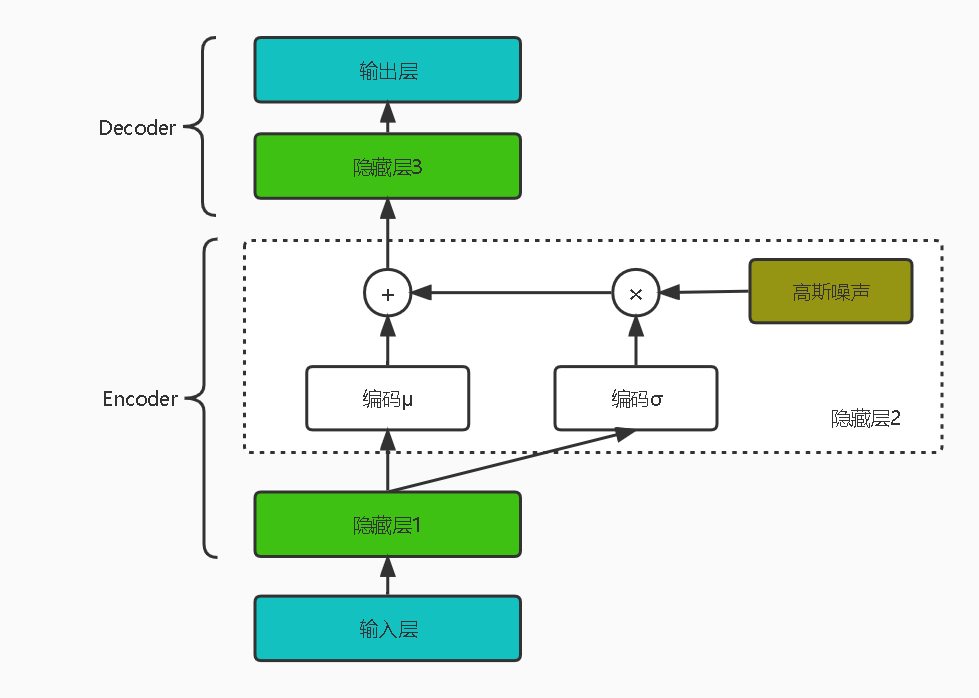
<center> VAE网络计算图

# 论文复现

## 准备阶段

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import random

系统配置

In [2]:
warnings.filterwarnings('ignore')   # 忽视调用文件时的警告信息
plt.rcParams["font.sans-serif"] = ["SimHei"]   # 支持绘图中文标签
plt.rcParams["axes.unicode_minus"] = False
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 如果电脑上有GPU则使用GPU设备，否则使用CPU

设置随机数种子

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
set_seed(0)

## 数据预处理

定义一个转换器，将数据转换为tensor格式

In [5]:
transform=transforms.Compose([transforms.ToTensor()])

手写数字图片是著名的数据集，pytorch中收录了该数据集，因此我们直接下载

In [6]:
train=torchvision.datasets.MNIST('./',download=True,transform=transform,train=True)
test=torchvision.datasets.MNIST('./',download=True,transform=transform,train=False)

我们取第一个样本看看

In [7]:
print(train[0])
print(type(train[0]))

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

可以看到第一个样本是一个元组数据类型，该元组包含两个数据（X,y）,X是一个tensor数据类型，代表图片的像素值，y是该图片的标签，第一个样本标签为5，代表这张图片是手写数字5

接下来我们看看图片的尺寸

In [8]:
print(train[0][0].shape)

torch.Size([1, 28, 28])


该图片是1通道，28 * 28的尺寸，常见的彩色图片格式是采用 RGB 3通道的像素值储存的手写数字数据集是黑白图片，因此是1通道

接下来我们看看样本量

In [9]:
train_size=len(train)
test_size=len(test)

In [10]:
print(train_size,test_size)

60000 10000


可以看到训练样本足足有60000张，测试样本为10000张

我们每次训练并不是训练全部样本，而是不重复地抽样一批次的样本进行训练，因此需要设置每次训练时所抽取的样本数

In [11]:
M=100   # 每次进行训练时选择的批量大小

In [12]:
trainloader=DataLoader(train,batch_size=M,shuffle=True,num_workers=0,drop_last=True)  
testloader=DataLoader(test,batch_size=M,shuffle=True,num_workers=0,drop_last=True)

## VAE模型的搭建

In [13]:
class VAE(nn.Module):
    
    def __init__(self,D_in,D_enc,D_z,D_dec,D_out):   
        super().__init__()
        self.linear1=nn.Linear(D_in,D_enc)
        self.linear21=nn.Linear(D_enc,D_z)
        self.linear22=nn.Linear(D_enc,D_z)
        self.linear3=nn.Linear(D_z,D_dec)
        self.linear4=nn.Linear(D_dec,D_out)
    
    def encode(self,x):    # 定义编码方法
        h=F.relu(self.linear1(x))
        mu=self.linear21(h)
        logsigma=self.linear22(h)   # 线性层逼近log(σ)好处在于线性函数可以输出负值，也能保证σ是非负的
        return mu,logsigma   # encoder输出μ和log(σ)的编码，只是一个线性关系，有正有负，没有非线性激活函数
    
    def reparameterize(self,mu,logsigma):    # 重参数化技巧
        sigma=torch.exp(logsigma)     # 还原σ
        mu,sigma=mu.to(device),sigma.to(device)
        self.mu=mu    # 记录编码后的mu
        self.sigma=sigma    # 记录编码后的sigma
        
        eps=torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()   # 随机采样高斯噪声
        eps=Variable(eps)    # 高斯噪声是可变张量
        eps=eps.to(device)   # 把张量放在GPU上
        z=mu + sigma * eps        
        return z   # 返回隐变量z
    
    def decode(self,z):    # 定义解码方法
        h=F.relu(self.linear3(z))     
        return F.sigmoid(self.linear4(h))   
    
    def forward(self,x,L):
        if L >1:
            outputs=torch.zeros(x.shape[0],L,x.shape[1])   # 解码器会输出三维张量，因为每一个样本会产生L个隐变量的编码
            for i in range(x.shape[0]):
                mu,logvar=self.encode(x[i])  # 记录一个样本经编码器后的输出
                for l in range(L):
                    z=self.reparameterize(mu,logvar)    # 随机采样L次高斯噪声，并重参数化z
                    output=self.decode(z)       # 解码
                    outputs[i,l,:]=output   # 记录该条输出
        else:
            mu,logvar=self.encode(x)
            z=self.reparameterize(mu,logvar)
            outputs=self.decode(z)
        return outputs

## 定义损失函数

In [14]:
class VAE_loss(nn.Module):
    
    def __init__(self,lmd):
        super().__init__()
        self.lmd = lmd    # 超参数lambda

    def forward(self, outputs, x, mu, sigma):
        if len(outputs.shape)>=3:     # 代表着 L > 1 
            total_recons_loss=0    # 记录该批样本的总重构损失
            for m in range(outputs.shape[0]):
                total_recons_loss_l=0     # 记录每一个样本经隐变量采样L次后的总损失
                for l in range(outputs.shape[1]):
                    recons_loss=nn.MSELoss(reduction='sum')(outputs[m,l,:],x[m]) # 计算重构损失
                    total_recons_loss_l+=recons_loss

                mean_recons_loss_l=total_recons_loss_l/outputs.shape[1] # 计算每一个样本经隐变量采样L次后的平均重构损失，outputs.shape[1]=L
                total_recons_loss+=mean_recons_loss_l

            mean_recons_loss=total_recons_loss/outputs.shape[0]   # 计算该批样本的平均损失，outputs.shape[0]=M
        else:
            mean_recons_loss=nn.MSELoss(reduction='mean')(outputs,x)
        
        latent_loss = 0.5 * torch.mean(torch.square(mu) + torch.square(sigma) - torch.log(torch.square(sigma)) - 1)   # 计算潜在损失
        return mean_recons_loss + self.lmd * latent_loss

## 进行实验

定义一个实验函数，方便后面更改隐变量维度继续实验

In [15]:
def experiment(trainloader,testloader,input_dim,N,N_z,N_h,lr=0.001,epochs=int(1e6),lmd=1,M=100,L=1):
    '''
    :param trainloader: 训练数据集的加载器
    :param testloader: 测试数据集的加载器
    :param input_dim: 输入维度
    :param N: 总样本量
    :param N_z: VAE隐变量z的维度
    :param N_h: 隐藏层的节点数，原文献在MNIST数据集上设置为500,Frey Face数据集上为200
    :param lr: 学习率，默认设置为0.001
    :param epochs: 迭代轮数，默认迭代10^6轮，训练10^8个样本
    :param lmd: 正则化系数，也是生成网络的方差，原文献是单位矩阵，因此默认设定为1
    :param M: AEVB算法中的每轮迭代训练样本数
    :param L: 采样的高斯噪声的样本数，用于期望的估计，原文献选择的是1，因此默认为1
    :return: 
    '''
    vae=VAE(input_dim,N_h,N_z,N_h,input_dim)
    vae=vae.to(device)    # 将模型放在GPU上

    loss_fn=VAE_loss(lmd)
    loss_fn=loss_fn.to(device)   # 将损失函数放在GPU上

    optimizer=optim.SGD(vae.parameters(),lr=lr)    # 原文献推荐SGD或Adagrad优化器，这里选择SGD

    train_samples = 0      
    train_samples_lst=[]   # 记录训练的样本数
    train_ELBO_lst=[]     # 记录训练集上的ELBO
    test_ELBO_lst=[]      # 记录测试集上的ELBO
    start_time=time.time()   # 记录开始时间
    
    for epoch in range(epochs):
        vae.train()   # 将模型设置为训练模式
        for data in trainloader:         # 在所有样本抽取M个样本，只抽一次，就退出循环进入下一轮迭代
            inputs,_=data       # 获取输入数据，因为我们是无监督学习，所以不用获取标签
            inputs=inputs.reshape(-1,28*28)      # 因为输入是一个28*28的2D图像，因此我们需要把他展平成28*28=784维的向量
            inputs=inputs.to(device)   # 将数据放在GPU上

            optimizer.zero_grad()   # 将梯度置零，每个批次样本之间是独立的，不能相互影响
            outputs=vae(inputs,L)    # 记录vae的输出，即数据经encoder,再经decoder后的输出
            outputs=outputs.to(device)    # 将输出数据放在GPU上

            train_loss=loss_fn(outputs, inputs, vae.mu, vae.sigma)    # 计算损失
            train_loss.backward()    # 误差反向传播
            optimizer.step()    # 更新模型参数
  
            train_samples+=M
            train_samples_lst.append(train_samples)
        
            train_loss=train_loss.cpu()    # 放回把loss放回CPU，绘图需在CPU上运行
            train_loss=train_loss.detach().numpy()   # 把数据卸下来，不用有梯度信息了，并转成numpy格式
            train_ELBO_lst.append(-train_loss*N)   # 依据式（18）和式（23），ELBO就是损失函数的负数
            break

        vae.eval()    # 将模型设置为验证模式
        with torch.no_grad():    # 梯度置零
            for data in testloader:
                inputs,_=data
                inputs=inputs.reshape(-1,28*28)
                inputs=inputs.to(device)
                outputs=vae(inputs,L)
                outputs=outputs.to(device)
                test_loss=loss_fn(outputs, inputs, vae.mu, vae.sigma)
                
                test_loss=test_loss.cpu()
                test_loss=test_loss.detach().numpy()  
                test_ELBO_lst.append(-test_loss*N)
                break
        
        if train_samples%int(1e5)==0:   
            print(f'------ train_samples = {train_samples} ------')
            print(f'train_loss = {train_loss:.4f}')
            print(f'test_loss = {test_loss:.4f}')
            
            end_time=time.time()
            print(f'总运行时间：{end_time-start_time:.2f}s')
            
    return train_samples_lst,train_ELBO_lst,test_ELBO_lst,vae

设定数据的输入维度和样本量

In [16]:
input_dim=28*28     # 输入维度
N=len(train)+len(test)   # 全部的样本数

### N_z=3

In [ ]:
N_z=3
train_samples_lst_3,train_ELBO_lst_3,test_ELBO_lst_3,vae_3=experiment(
    trainloader,
    testloader,
    input_dim,
    N,
    N_z=N_z,
    N_h=500,
    lr=0.001,
    epochs=int(1e5), # 由于训练回合数太多速度太慢，我们减少迭代轮数
    lmd=1,
    M=100,
    L=1
)

------ train_samples = 100000 ------
train_loss = 0.2389
test_loss = 0.2375
总运行时间：46.01s
------ train_samples = 200000 ------
train_loss = 0.2347
test_loss = 0.2348
总运行时间：92.31s
------ train_samples = 300000 ------
train_loss = 0.2320
test_loss = 0.2322
总运行时间：138.74s
------ train_samples = 400000 ------
train_loss = 0.2294
test_loss = 0.2293
总运行时间：184.94s
------ train_samples = 500000 ------
train_loss = 0.2261
test_loss = 0.2271
总运行时间：231.56s
------ train_samples = 600000 ------
train_loss = 0.2248
test_loss = 0.2242
总运行时间：278.68s
------ train_samples = 700000 ------
train_loss = 0.2220
test_loss = 0.2215
总运行时间：325.14s
------ train_samples = 800000 ------
train_loss = 0.2196
test_loss = 0.2191
总运行时间：371.44s
------ train_samples = 900000 ------
train_loss = 0.2171
test_loss = 0.2171
总运行时间：417.72s
------ train_samples = 1000000 ------
train_loss = 0.2154
test_loss = 0.2140
总运行时间：464.10s
------ train_samples = 1100000 ------
train_loss = 0.2126
test_loss = 0.2122
总运行时间：510.58s
------ tra

### N_z=5

In [ ]:
N_z=5
train_samples_lst_5,train_ELBO_lst_5,test_ELBO_lst_5,vae_5=experiment(trainloader,
                                                                       testloader,
                                                                       input_dim,
                                                                       N,
                                                                       N_z=N_z,
                                                                       N_h=500,
                                                                       lr=0.001,
                                                                       epochs=int(1e5),
                                                                       lmd=1,
                                                                       M=100,
                                                                       L=1)

### N_z=10

In [ ]:
N_z=10
train_samples_lst_10,train_ELBO_lst_10,test_ELBO_lst_10,vae_10=experiment(trainloader,
                                                                       testloader,
                                                                       input_dim,
                                                                       N,
                                                                       N_z=N_z,
                                                                       N_h=500,
                                                                       lr=0.001,
                                                                       epochs=int(1e5),
                                                                       lmd=1,
                                                                       M=100,
                                                                       L=1)

## 试验结果展示

In [ ]:
def show(x,y1,y2,N_z):
    plt.figure(figsize=(5,5))
    plt.plot(x,y1)
    plt.plot(x,y2,linestyle='--')
    plt.legend(['AEVB(train)','AEVB(test)'])
    plt.ylabel('L')
    plt.title(f'MNIST,Nz={N_z}')

In [ ]:
show(train_samples_lst_3,train_ELBO_lst_3,test_ELBO_lst_3,3)

In [ ]:
show(train_samples_lst_5,train_ELBO_lst_5,test_ELBO_lst_5,5)

In [ ]:
show(train_samples_lst_10,train_ELBO_lst_10,test_ELBO_lst_10,10)

## 可视化展示

In [ ]:
train=train.data.float().to(device)
test=test.data.float().to(device)

In [ ]:
def display(n_image,data_disp,vae):
    fig=plt.figure(figsize=(n_image*1.5,3))
    for i in range(n_image):
        plt.subplot(2,n_image,1+i)
        plt.imshow(data_disp.data[i].cpu(),cmap='gray')
        plt.axis('off')
        plt.subplot(2,n_image,1+n_image+i)
        outputs=vae(data_disp.data[i].reshape(-1,28*28))
        outputs=outputs.cpu()           # 把输出值放回CPU展示
        outputs=outputs.data[0].numpy().reshape(28,28)
        plt.imshow(outputs,cmap='gray')
        plt.axis('off')

In [ ]:
display(5,test,vae_3)

In [ ]:
display(5,test,vae_5)

In [ ]:
display(5,test,vae_10)

# 继续阅读

&emsp;&emsp;尽管本篇论文非常经典，但是还是有点晦涩难懂，有两篇关于VAE的详细介绍，都是基于本篇论文的补充和教程，一篇是《Tutorial on Variational Autoencoders》，另一篇是《An Introduction to Variational Autoencoders》，更推荐后者，后者就是原作者Diederik P. Kingma和Max Welling写的，介绍的更加详细，VAE的前因后果、详细的数学推导、AVEB算法等等，都进行了详细的介绍。这两篇论文都打包在本次复现的附录里了。

# 参考文献

[1] Diederik P. Kingma, Max Welling, 2019, An Introduction to Variational Autoencoders[M]. $Foundations \;and\; Trends^R\;in\;Machine\;Learning$.\
[2] Doersch C, 2016. Tutorial on Variational Autoencoders[J]. $CoRR$.\
[3] 邱锡鹏, 2020, 神经网络与深度学习[M]. 机械工业出版社.\
[4] Aurelien Geion, 2020, 机器学习实战（第二版）[M]. 机械工业出版社.